---
layout: post
title:  "Localization Learning Part 7"
tags:
  - deep learning
  - machine learning
  - tensorflow 2
  - Localization
  - tf.keras.utils.Sequence
  - transfer learning
  - vgg16
---


This is my implementation of the Localization part 7 lectures from Lazy Programmer's Deep Learning and Advanced Computer Vision course. In this section we train the model to distinguish between three different Pokemon as well as detect whether a Pokemon exists in the scene and where it is.

We do this by adding an additional 3 outputs to the model that use the softmax activation function, and classify the Pokemon type if one is present in the scene.

Code for this article can be found at [https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-7.ipynb](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-7.ipynb)

In [120]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image, ImageDraw

IMAGE_DIM = 200

I started with the final code from [Localization 6](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-6.ipynb) and then made the necessary modifications from there using the same background photo by [Patrick Szylar](https://unsplash.com/@patrick_szylar?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) on [Unsplash](https://unsplash.com/s/photos/outdoor?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText)


To combine the Pokemon and background images together, as before, I used the [`Image.alpha_composite()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.alpha_composite) function from Pillow which ensures that the transparency is respected.


In order to randomly generate some images with a Pokemon and some without, I updated the `generate_image()` function so that it only generates an image with a Pokemon in it 50% of the time.

In [121]:
class LocalizationSequence(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        with Image.open('assets/images/charmander.png') as ch, \
             Image.open('assets/images/bulbasaur.png') as bu, \
             Image.open('assets/images/squirtle.png') as sq, \
             Image.open('assets/images/landscape.png') as bg:
                
            self.pokemon = [ch.copy(), bu.copy(), sq.copy()]
            self.background = bg.copy()
        
        
    def preprocess_y_value(self, y):
        """
        Sets the range of y to 0..1.
        """
        return y / IMAGE_DIM
        

    def generate_background(self):
        """
        Generates a background image by cropping out a part of the
        background image.
        """
        left = random.randint(0, self.background.width - IMAGE_DIM)
        top = random.randint(0, self.background.height - IMAGE_DIM)
        return self.background.crop((left, top, left + IMAGE_DIM, top + IMAGE_DIM))

        
    def generate_pokemon(self, i):
        """
        Generates a Charmander pokemon of a random size from 0.5 to
        1.5 the scale of the original one and flipped left to right
        50% of the time.
        """
        scale = random.uniform(0.5, 1.5)
        poke = self.pokemon[i].resize(
            (int(self.pokemon[i].width * scale), 
             int(self.pokemon[i].height * scale))
        )

        if random.random() > 0.5:
            poke = poke.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
            
        return poke
        
        
    def generate_image(self):
        """
        Generates a random image with a Charmander inside it. 
        """
        
        # start by generating the background
        img = self.generate_background()

        # some default values i case we don't end up generating a pokemon
        char_width, char_height, char_left, char_top = 0, 0, 0, 0

        # decide if to generate a pokemon and if so, which one
        poke_idx = random.randint(0, len(self.pokemon))
        
        include_pokemon = 1. if poke_idx < len(self.pokemon) else 0.
        
        # if poke_idx is 4 then don't generate a pokemon otherwise
        # poke_idx is the index of the pokemon in the pokemon array
        if include_pokemon ==1.:
            
            # generate the pokemon
            poke = self.generate_pokemon(poke_idx)
            (char_width, char_height) = poke.size

            # place the charminder randomly in the image
            char_left = random.randint(0, img.width - char_width)
            char_top = random.randint(0, img.height - char_height)

            # combine the two together
            img.alpha_composite(poke, dest=(char_left, char_top))
        
        # create a numpy array from the image and strip out the
        # alpha channel
        img_arr = np.array(img)[:, :, 0:3]
        
        # normalize colours
        img_arr = img_arr / 255.
        
        # normalise the values relating to dimensions
        dims = np.array([char_top, char_left, char_height, char_width]) / IMAGE_DIM
        
        # create three values to indicate which pokemon we're showing
        poke = np.zeros((4,))
        if include_pokemon == 1.:
            poke[poke_idx] = 1.
            poke[-1] = 1.
        
        return img_arr, np.append(dims, poke)
        
        
    def __len__(self):
        """
        We generate the images on the fly so just return a high number.
        """
        return 1000
    
    
    def __getitem__(self, idx):
        """
        Return a batch of images preprepared for training. I.e. colour ranges
        are 0..1 and not 0..255.
        """
        batch_x = np.empty(
            [self.batch_size, IMAGE_DIM, IMAGE_DIM, 3], 
            dtype=np.float32
        )
        batch_y = np.empty([self.batch_size, 8], dtype=np.float32)
        
        for i in range(self.batch_size):
            batch_x[i], batch_y[i] = self.generate_image()
            
        return batch_x, batch_y
    


Let's test that out and see what it generates.

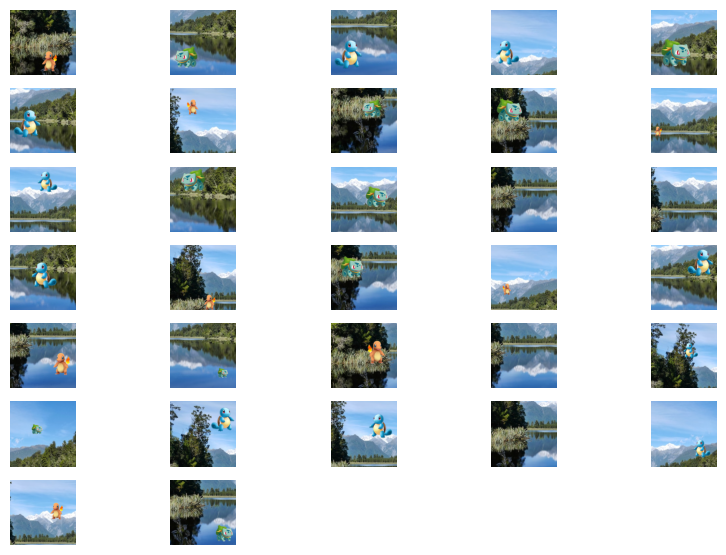

In [122]:
pokemon_categories = ["Charminder", "Bulbasaur", "Squirtle"]
seq = LocalizationSequence(batch_size=32)
batch_x, batch_y = seq.__getitem__(0)

plt.rcParams["figure.figsize"] = (10, 10)
for i in range(min(50, seq.batch_size)):
    ax = plt.subplot(10, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(batch_x[i])
    
plt.show()

Next, have a quick check of the Y data to make sure it's generated the right thing.

In [123]:
batch_y

array([[0.64 , 0.485, 0.305, 0.23 , 1.   , 0.   , 0.   , 1.   ],
       [0.565, 0.07 , 0.325, 0.345, 0.   , 1.   , 0.   , 1.   ],
       [0.475, 0.055, 0.43 , 0.415, 0.   , 0.   , 1.   , 1.   ],
       [0.48 , 0.075, 0.365, 0.35 , 0.   , 0.   , 1.   , 1.   ],
       [0.45 , 0.16 , 0.415, 0.435, 0.   , 1.   , 0.   , 1.   ],
       [0.35 , 0.06 , 0.415, 0.405, 0.   , 0.   , 1.   , 1.   ],
       [0.19 , 0.255, 0.23 , 0.175, 1.   , 0.   , 0.   , 1.   ],
       [0.185, 0.475, 0.275, 0.29 , 0.   , 1.   , 0.   , 1.   ],
       [0.17 , 0.09 , 0.365, 0.38 , 0.   , 1.   , 0.   , 1.   ],
       [0.6  , 0.05 , 0.15 , 0.115, 1.   , 0.   , 0.   , 1.   ],
       [0.085, 0.42 , 0.31 , 0.295, 0.   , 0.   , 1.   , 1.   ],
       [0.04 , 0.17 , 0.345, 0.36 , 0.   , 1.   , 0.   , 1.   ],
       [0.305, 0.53 , 0.315, 0.335, 0.   , 1.   , 0.   , 1.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.28 , 0.325, 0.3

To read the 'pokemon generated / detected' data, we can slice out the last value in each row.

In [124]:
batch_y[:,-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

The Pokemon character class data comes from the values at indexes 4, 5 and 6.

In [125]:
batch_y[:,4:7]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

As previously, the location, width and height data is in the first 4 values of each array item.

In [126]:
batch_y[:,0:4]

array([[0.64 , 0.485, 0.305, 0.23 ],
       [0.565, 0.07 , 0.325, 0.345],
       [0.475, 0.055, 0.43 , 0.415],
       [0.48 , 0.075, 0.365, 0.35 ],
       [0.45 , 0.16 , 0.415, 0.435],
       [0.35 , 0.06 , 0.415, 0.405],
       [0.19 , 0.255, 0.23 , 0.175],
       [0.185, 0.475, 0.275, 0.29 ],
       [0.17 , 0.09 , 0.365, 0.38 ],
       [0.6  , 0.05 , 0.15 , 0.115],
       [0.085, 0.42 , 0.31 , 0.295],
       [0.04 , 0.17 , 0.345, 0.36 ],
       [0.305, 0.53 , 0.315, 0.335],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.28 , 0.325, 0.39 , 0.38 ],
       [0.77 , 0.515, 0.23 , 0.175],
       [0.185, 0.15 , 0.325, 0.34 ],
       [0.6  , 0.175, 0.175, 0.13 ],
       [0.085, 0.555, 0.4  , 0.39 ],
       [0.47 , 0.655, 0.335, 0.255],
       [0.695, 0.725, 0.15 , 0.155],
       [0.285, 0.555, 0.35 , 0.265],
       [0.   , 0.   , 0.   , 0.   ],
       [0.32 , 0.49 , 0.23 , 0.22 ],
       [0.35 , 0.33 , 0.155, 0.165],
       [0.1  , 0.625, 0.36 , 0.35 ],
 


With the addition of the Pokemon classification, we need to change the loss function again. This time we use Categorical Crossentropy for the Pokemon type and Binary Crossentropy for the location and 'detect' values. A new weight coefficient is also added so we can tweak the algorithm to favour particular losses. Note also, that the Pokemon classification is only included in the loss when a Pokemon is present in the scene.

As in Lazy Programmer's lecture, we also want to weight the relative importance of detecting a Pokemon vs locating it in the image. The custom loss function can therefore be given as:

$$ loss = \alpha L_{bce}(Y_{[1..4]}, \hat{Y}_{[1..4]})Y_{[8]} + \beta L_{cce} (Y_{[5..7]}, \hat{Y}_{[5..7]})Y_{[8]} + \gamma L_{bce}(Y_{[8]}, \hat{Y}_{[8]})$$

Where:

&emsp;$\alpha$, $\beta$ and $\gamma$ are the weightings for the location, classification and detect losses  
&emsp;$L_{bce}$ represets the binary crossentropy loss function  
&emsp;$L_{cce}$ represets the categorical crossentropy loss function  
&emsp;$Y_{[1..4]}$ and $\hat{Y}_{[1..4]}$ represent the actual and predicted location outputs  
&emsp;$Y_{[5..7]}$ and $\hat{Y}_{[5..7]}$ represent the actual and predicted pokemon classification outputs  
&emsp;$Y_{[8]}$ and $\hat{Y}_{[8]}$ represent the actual and predicted detect outputs  

As previously, the 'detect' value is used to ignore values for loss in the location and classification outputs if no Pokemon is generated in the scene by multiplying it with those outputs. 

The custom loss is created as a class derived from the Keras Loss class as shown in the Tensorflow documentation at [https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss)

In [127]:
class PokemonBinaryCrossEntropyError(tf.keras.losses.Loss):
    
    def __init__(self):
        super().__init__()
        self.binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
        self.categorical_crossentropy = tf.keras.losses.CategoricalCrossentropy()
        self.weight_alpha = 1.
        self.weight_beta = 1.
        self.weight_gamma = 0.5
        
    def call(self, y_true, y_pred):
        position_loss = self.binary_crossentropy(y_true[:,0:4], y_pred[:, 0:4])
        pokemon_loss = self.categorical_crossentropy(y_true[:,4:7], y_pred[:, 4:7])
        detect_loss = self.binary_crossentropy(y_true[:, -1], y_pred[:, -1])

        rv = self.weight_alpha * position_loss * y_true[:, -1] + \
            self.weight_beta * pokemon_loss * y_true[:, -1] + \
            self.weight_gamma * detect_loss
        
        return rv

As before, we're using the Adam optimizer.

In [128]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

Next we create the model as before.

In [129]:
# create the model
vgg16 = tf.keras.applications.vgg16.VGG16(
    input_shape=(IMAGE_DIM, IMAGE_DIM, 3), 
    include_top=False, 
    weights='imagenet'
)

# we don't want to train the VGG16 model
vgg16.trainable = False

# create the dense layer
x = tf.keras.layers.Flatten()(vgg16.output)

x1 = tf.keras.layers.Dense(4, activation="sigmoid")(x)
x2 = tf.keras.layers.Dense(3, activation="softmax")(x)
x3 = tf.keras.layers.Dense(1, activation="sigmoid")(x)

x = tf.keras.layers.Concatenate()([x1, x2, x3])


# and build and compile it
model = tf.keras.Model(vgg16.input, x, name="Localization_Model")
model.compile(loss=PokemonBinaryCrossEntropyError(), optimizer=opt)
model.summary()

Model: "Localization_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                

Then we train the model using the image generator.

In [130]:
history = model.fit(seq, epochs=25, steps_per_epoch=50)

Epoch 1/25
50/50 [==============================] - 218s 4s/step - loss: 1.2190
Epoch 2/25
50/50 [==============================] - 231s 5s/step - loss: 1.0429
Epoch 3/25
50/50 [==============================] - 242s 5s/step - loss: 0.9266
Epoch 4/25
50/50 [==============================] - 242s 5s/step - loss: 0.8191
Epoch 5/25
50/50 [==============================] - 246s 5s/step - loss: 0.7760
Epoch 6/25
50/50 [==============================] - 245s 5s/step - loss: 0.7248
Epoch 7/25
50/50 [==============================] - 247s 5s/step - loss: 0.6920
Epoch 8/25
50/50 [==============================] - 248s 5s/step - loss: 0.6793
Epoch 9/25
50/50 [==============================] - 248s 5s/step - loss: 0.6521
Epoch 10/25
50/50 [==============================] - 258s 5s/step - loss: 0.6093
Epoch 11/25
50/50 [==============================] - 262s 5s/step - loss: 0.6092
Epoch 12/25
50/50 [==============================] - 260s 5s/step - loss: 0.6198
Epoch 13/25
50/50 [==================

Plot the loss from the `model.fit()`.

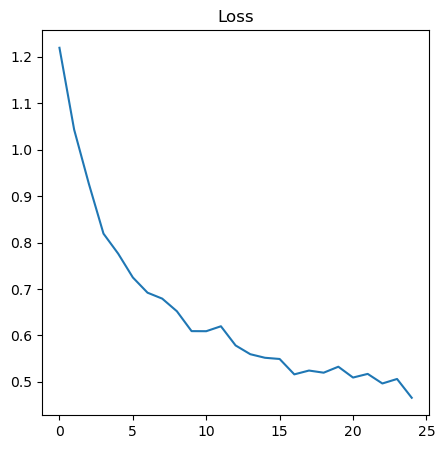

In [131]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.show()

Training can take some time so save out the model so it can be loaded from disk in future.

In [132]:
model.save('saved-models/localization-7.h5', overwrite=True)

The `to_pil_rect()` function takes the y outputs from the model and converts the values into the correct coordinates for the image. We only want to do that for the location and size values though, not for the detect values. We also have to convert width and height into right and bottom values by adding them to the left and top values. I had to make a small modification to the code from the previous lecture to take into account the change in array shape.

In [133]:
def to_pil_rect(y):
    rv = np.copy(y)
    rv[:, :4] = rv[:, :4] * IMAGE_DIM
    rv[:, 2:4] = rv[:, 2:4] + rv[:, 0:2]
    return rv

The sequence object can be used to create a set of images we can use for prediction.

In [134]:
x, y = seq.__getitem__(0)

Use the trained model to make some predictions from the new batch.

In [135]:
y_predicted = model.predict(x)

1/1 [==============================] - 5s 5s/step


In [136]:
print(f'{y_predicted}')

[[5.04656017e-01 4.55304623e-01 1.74794450e-01 1.78234190e-01
  1.06209539e-01 8.83485675e-01 1.03048189e-02 9.93664682e-01]
 [1.88276991e-01 3.24535072e-01 2.56809354e-01 2.74745524e-01
  7.59936636e-03 9.91005301e-01 1.39535533e-03 9.98976707e-01]
 [2.13018909e-01 2.24052340e-01 4.52457279e-01 4.31486011e-01
  1.88289705e-04 9.99429047e-01 3.82720231e-04 9.99954641e-01]
 [2.46565834e-01 7.16228336e-02 1.31003067e-01 1.31195873e-01
  3.30779344e-01 1.42577708e-01 5.26642978e-01 8.56770694e-01]
 [1.59132048e-01 4.01893437e-01 4.89614993e-01 4.63358134e-01
  3.31727564e-02 1.77443586e-03 9.65052843e-01 9.99997318e-01]
 [6.78105474e-01 2.03255162e-01 2.19602332e-01 1.78929970e-01
  7.92663395e-01 1.67997375e-01 3.93391736e-02 9.89245176e-01]
 [1.81751430e-01 2.40194067e-01 3.45277101e-01 3.16684693e-01
  2.64868677e-01 1.25545962e-02 7.22576678e-01 9.99791384e-01]
 [2.40646586e-01 2.80282468e-01 1.56318620e-01 1.41708091e-01
  7.76130408e-02 1.96323860e-02 9.02754605e-01 9.84547496e-01]


Create the boxes for both the actual boxes and the predicted ones.

In [137]:
predicted_boxes = to_pil_rect(y_predicted)
actual_boxes = to_pil_rect(y)

Next we create a function that takes each of the images used in the predictions and adds the predicted bounding boxes. I did this using the Pillow library but it's probably pretty straightforward to use Numoy or tf functions to do it too.

In [138]:
def add_bounding_boxes():
    """
    Adds the bounding boxes to the images used in the prediction.
    """
    rv = np.zeros((seq.batch_size, IMAGE_DIM, IMAGE_DIM, 3), dtype=np.uint8)
    for i in range(seq.batch_size):
        im = Image.fromarray(np.uint8(x[i] * 255), mode='RGB')

        draw = ImageDraw.Draw(im)
        
        # add the bounding rectangle if something was detected
        if predicted_boxes[i, -1] > 0.5:

            draw.rectangle(
                [predicted_boxes[i, 1], 
                 predicted_boxes[i, 0], 
                 predicted_boxes[i, 3], 
                 predicted_boxes[i, 2]], outline='green')
        
        rv[i] = np.array(im).astype(dtype=np.uint8)

    return rv

In [139]:
final_images = add_bounding_boxes()

Now we can draw some of the images that were used to create the predictions and overlay the localization rectangles on top of them as before.

In [140]:
pokemon_categories = ["Charminder", "Bulbasaur", "Squirtle"]
def get_pokemon_name_from_prediction(y):
    a = y[4:7]
    d = y[-1] > 0.5
    return pokemon_categories[np.argmax(a)] if d else "None"

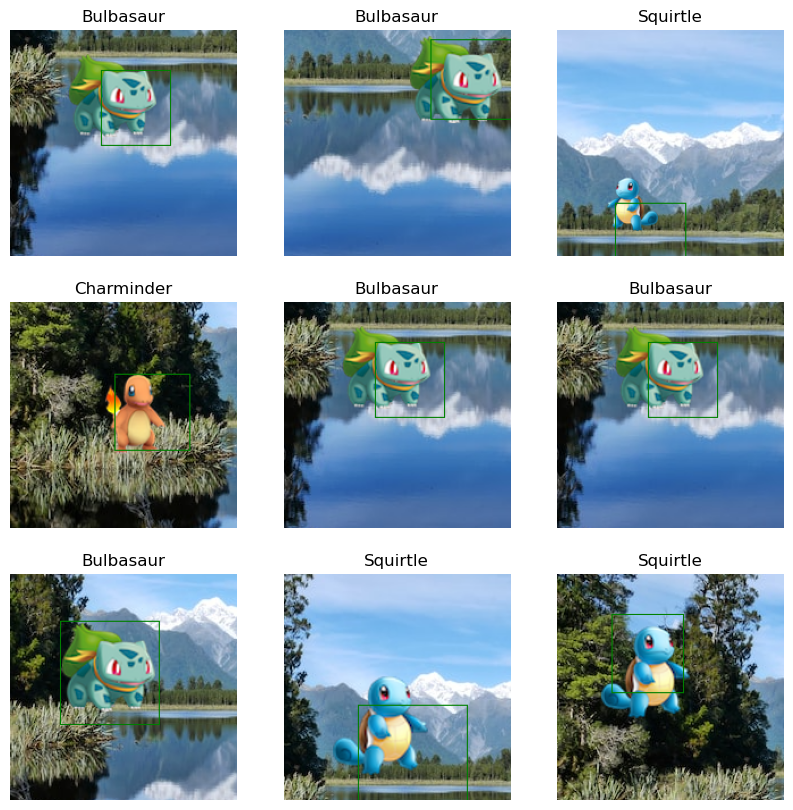

In [141]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    im_idx = random.randint(0, seq.batch_size - 1)
    ax.imshow(final_images[im_idx])
    ax.set_axis_off()
    ax.set_title(f'{get_pokemon_name_from_prediction(predicted_boxes[im_idx])}')

In the output above you can see the green boxes that are the results of the predictions. You can see that some of the predictions are a bit off so again so it might be worth training for more epochs to see if a bit more accuracy can be obtained that way. Note that the loss curve from training looked as though it could be pushed a bit further.

This is the end of the Localization lectures from the course. Overall, it's been an interesting exercise to work through them all one-by-one and gradually build up to the final code. It's taught me  a lot about using the Tensorflow library, how to build custom models and make use of transfer learning. It also showed me how to build models with layers that use different activation functions using the `Concatenate` class and how to write custom loss functions by deriving from the `Loss` class in Tensorflow.

For my next project, I'm going to see if I can take a paper from [https://arxiv.org/](https://arxiv.org/) and I'll post progress on that as I go.